<a href="https://colab.research.google.com/github/sharonshuang/models/blob/master/CovidModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random


In [ ]:
def plotdata(t, s, i, r, e=None):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, s, lw=3, label='Fraction Susceptible')
    ax[0].plot(t, i, lw=3, label='Fraction Infective')
    ax[0].plot(t, r, lw=3, label='Recovered')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective')
    ax[1].set_title('Infectious Population')
    if e is not None: ax[1].plot(t, e, lw=3, label='Exposed')
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(s, i, lw=3, label='s, i trajectory')
    ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(s[0], i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(s[-1], i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()

Original SEIR with set parameters

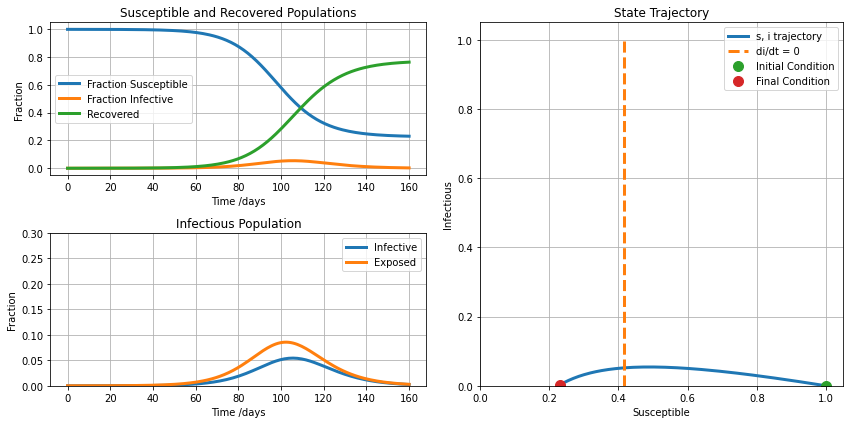

In [ ]:

# parameter values
u = 0.2
R0 = 2.4
t_incubation = 5.1
t_infective = 3.3

# initial number of infected and recovered individuals
e_initial = 1/20000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u)*beta * s * i
    dedt =  (1-u)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 160, 160)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T

plotdata(t, s, i, r, e)

Boldog, et al. Improving Fidelity of Model 

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


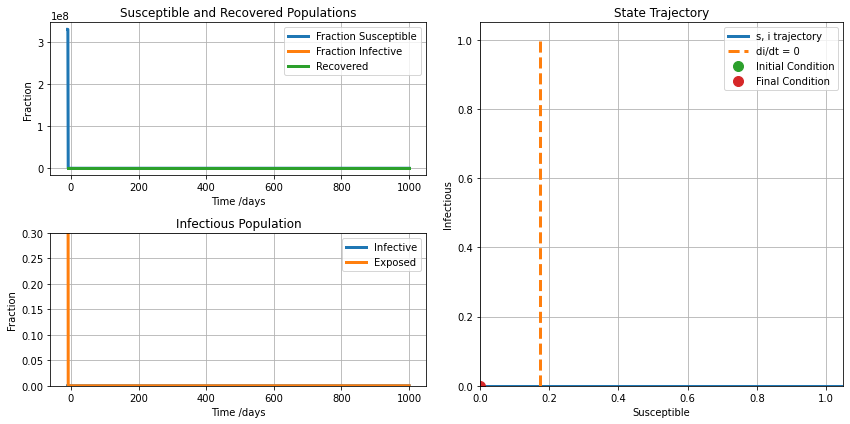

In [ ]:


u = 0.3
mu = 0
alpha = 1/5.6   # incubation period
R0 = 5.8
gamma = 3.3
beta = R0*gamma
vaxef = 0.7

N = 331000000
random.seed(30)

def SEIR(x, t):
    S, E1, E2, I1, I2, I3, R = x
    b = beta + np.random.poisson(R0*gamma, 1) # find poisson distribution model it according for beta
    dS = -(1-u)*b*S*(I1 + I2 + I3)/N + u*(E2 + E1)/N + (1-vaxef)*R/N
    dE1 = -dS - 2*alpha*E1
    dE2 = 2*alpha*E1 - 2*alpha*E2
    dI1 = 2*alpha*E2 - 3*gamma*I1 - mu*I1
    dI2 = 3*gamma*I1 - 3*gamma*I2 - mu*I2 #+ np.tanh(50)
    dI3 = 3*gamma*I2 - 3*gamma*I3 - mu*I3
    dR = 3*gamma*I3 - (1-vaxef)*R
    dB = b + dR * gamma
    return [dS, dE1, dE2, dI1, dI2, dI3, dR]


IC = [N, 1, 0, 0, 0, 0, 0]
t = np.linspace(-10, 1000, 1000)

#todo: 
  #write for loop, where loop calculates soln over and over again; all with 
  #changing Betas throughout time; plot the last soln

soln = odeint(SEIR, IC, t)

s = soln[:, 0]
e = soln[:, 1] + soln[:, 2]
i = soln[:, 3] + soln[:, 4] + soln[:, 5]
r = soln[:, 6]


plotdata(t, s, i, r, e)



# LSTM Model Start


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
pd.set_option('precision',0)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
table = pd.read_csv('.../Documents/Covid detection/covid_19_data.csv',parse_dates=['ObservationDate'])
pd.set_option('display.max_rows', table.shape[0]) 
pd.set_option('display.max_columns', None)
table.style.set_properties(subset=['ad_description'], **{'width-max': '100px'})
table.head(10).style.background_gradient(cmap='cool')

table = pd.read_csv('.../Documents/Covid detection/covid_19_data.csv',parse_dates=['ObservationDate'])
pd.set_option('display.max_rows', table.shape[0]) 
pd.set_option('display.max_columns', None)
table.style.set_properties(subset=['ad_description'], **{'width-max': '100px'})
table.tail(10).style.background_gradient(cmap='cool')

table['Country/Region'].value_counts().head(20)

table.isnull().sum()


In [ ]:
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
table['Active'] = table['Confirmed'] - table['Deaths'] - table['Recovered']
table[['Province/State']] = table[['Province/State']].fillna('')
table[cases] = table[cases].fillna(0)
latest = table[table['ObservationDate'] == max(table['ObservationDate'])].reset_index()

latest_grouped = latest['Confirmed'] - latest['Deaths'] - latest['Recovered']
latest_grouped = latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

pred = latest_grouped.sort_values(by='Confirmed', ascending=False)
pred = pred.reset_index(drop=True)
cm = sns.light_palette("red", as_cmap=True)
pred.head(11).style.background_gradient(cmap=cm).background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Blues',subset=["Active"]).background_gradient(cmap='Oranges',subset=["Confirmed"])

LSTM

In [ ]:
lstm_data = table.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
lstm_data

training_set = lstm_data.iloc[:,0:1].values
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

X, y = [], []
time_steps = 45
for i in range(len(training_set) - time_steps):
    x = training_set_scaled[i:(i+time_steps), 0]
    X.append(x)
    y.append(training_set_scaled[i+time_steps, 0])
X = np.array(X)
y = np.array(y)
 
split = int(len(X) * 0.8)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(48))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

from keras.callbacks import ReduceLROnPlateau
batchsize = 100
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
history = model.fit(X_train,
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test.reshape(-1,1))
plt.plot(y_pred, color='red')
plt.plot(y_test, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])